<a href="https://colab.research.google.com/github/mhasan502/Age_Estimation/blob/Jibon/Age_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# custom_loader

## Installing Required Packages

In [137]:
!pip install parse
!pip install decouple

## Importing Required Packages

In [138]:
import os
import sys
import torch
import zipfile
import decouple
from PIL import Image
from parse import parse
from torch.utils.data import DataLoader, Dataset

# zip_pass = decouple.config("ZIP_KEY")

## DataLoader Classes

In [139]:
class AgeDBHandler:
    def __init__(self, datasets_dir, preload=False, device: torch.device = torch.device('cpu')):
        self.device = device
        self.preload = preload

        self.datasets_dir = datasets_dir
        self.directory = os.path.join(datasets_dir, 'AgeDB')
        self.zipFile = os.path.join(datasets_dir, 'AgeDB.zip')

        self.trainDataset = None
        self.testDataset = None
        self.validateDataset = None

        self._prepare_on_disk()
    
    def _prepare_on_disk(self):
        if os.path.exists(self.directory):
            if len(os.listdir(self.directory)) != 0:    # Already directory exists
                return
        
        print('Could not find AgeDB on', self.directory)
        print('Looking for ', self.zipFile)

        if os.path.exists(self.zipFile):

            print(self.zipFile, 'is found. Trying to extract:')
            with zipfile.ZipFile(self.zipFile) as zf:
                zf.extractall(pwd=zip_pass, path=self.datasets_dir)

            print('Successfully extracted')

        else:
            sys.exit('AgeDB Zip file not found!')


In [140]:
class AgeDBDataset(Dataset):
    def __init__(self, directory, transform, preload=False, device: torch.device = torch.device('cpu'), **kwargs):
        self.device = device
        self.directory = directory
        self.transform = transform        
        self.labels = []
        self.images = []
        self.preload = preload
        
        for i, file in enumerate(sorted(os.listdir(self.directory))):
            file_labels = parse('{}_{person}_{age}_{gender}.jpg', file)
            
            if file_labels is None:
                continue
                
            if self.preload:
                image = Image.open(os.path.join(self.directory, file)).convert('RGB')
                
                if self.transform is not None:
                    image = self.transform(image).to(self.device)
            else:
                image = os.path.join(self.directory, file)

            self.images.append(image)
            gender_to_class_id = {
                'm': 0,
                'f': 1
                }
            gender = gender_to_class_id[file_labels['gender']]
            person = str(file_labels['person'])
            age = int(file_labels['age'])
            self.labels.append({
                'person': person,
                'age': age,
                'gender': gender
            })

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]

        if not self.preload:
            image = Image.open(image).convert('RGB')
            if self.transform is not None:
                image = self.transform(image).to(self.device)

        labels = {
            'person': self.labels[idx]['person'], 
            'age': self.labels[idx]['age'], 
            'gender': self.labels[idx]['gender']
            }
        return image.to(self.device), labels
    

    def get_loaders(self, transform, batch_size, train_size, test_size, **kwargs):

        train_len = int(len(self) * train_size)
        test_len = int(len(self) * test_size)
        validate_len = len(self) - (train_len + test_len)

        self.trainDataset, self.validateDataset, self.testDataset = torch.utils.data.random_split(
            dataset = self, 
            lengths = [train_len, validate_len, test_len], 
            generator = torch.Generator().manual_seed(42)
        )

        train_loader = DataLoader(self.trainDataset, batch_size=batch_size)
        validate_loader = DataLoader(self.validateDataset, batch_size=batch_size)
        test_loader = DataLoader(self.testDataset, batch_size=batch_size)

        return train_loader, validate_loader, test_loader


# Preprocessing

## Importing Required Packages

In [141]:
from torch import nn
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [142]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Loading Dataset

In [143]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [144]:
inside = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/')
for i in range(20):
    print(inside[i])

15588_KateOMara_32_f.jpg
15658_KatharineRoss_68_f.jpg
15741_MaryTamm_40_f.jpg
15661_KatharineRoss_72_f.jpg
15621_KateOMara_70_f.jpg
15646_KatharineRoss_46_f.jpg
15851_StВphaneAudran_22_f.jpg
15810_SarahDouglas_61_f.jpg
15486_JeanetteMacDonald_46_f.jpg
15831_StefaniePowers_56_f.jpg
15670_KathrynGrayson_26_f.jpg
15539_JulieBishop_36_f.jpg
15696_KathrynGrayson_75_f.jpg
15738_MaryTamm_33_f.jpg
15853_StВphaneAudran_24_f.jpg
15665_KathrynGrayson_21_f.jpg
15815_StefaniePowers_24_f.jpg
15748_MaryTamm_51_f.jpg
15759_PamelaSueMartin_26_f.jpg
15799_SarahDouglas_43_f.jpg


In [145]:
sorted_dir = sorted(os.listdir('/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/'))
for i in range(20):
    print(sorted_dir[i])

0_MariaCallas_35_f.jpg
10000_GlennClose_62_f.jpg
10001_GoldieHawn_23_f.jpg
10002_GoldieHawn_24_f.jpg
10003_GoldieHawn_24_f.jpg
10004_GoldieHawn_27_f.jpg
10005_GoldieHawn_28_f.jpg
10006_GoldieHawn_29_f.jpg
10007_GoldieHawn_30_f.jpg
10008_GoldieHawn_31_f.jpg
10009_GoldieHawn_35_f.jpg
1000_StephenHawking_1_m.jpg
10010_GoldieHawn_35_f.jpg
10011_GoldieHawn_37_f.jpg
10012_GoldieHawn_39_f.jpg
10013_GoldieHawn_44_f.jpg
10014_GoldieHawn_45_f.jpg
10015_GoldieHawn_45_f.jpg
10016_GoldieHawn_50_f.jpg
10017_GoldieHawn_51_f.jpg


In [146]:
dataset = AgeDBDataset(
    directory = '/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB',
    transform = ToTensor(),
    device = device
)

## Dataset Attributes

In [147]:
len(dataset)

16488

In [148]:
dataset[0]

(tensor([[[0.4275, 0.4314, 0.4353,  ..., 0.4118, 0.4118, 0.4078],
          [0.4275, 0.4314, 0.4353,  ..., 0.4275, 0.4235, 0.4196],
          [0.4275, 0.4314, 0.4353,  ..., 0.4471, 0.4471, 0.4431],
          ...,
          [0.6667, 0.6706, 0.6745,  ..., 0.7333, 0.7333, 0.7333],
          [0.6706, 0.6745, 0.6784,  ..., 0.7176, 0.7176, 0.7176],
          [0.6745, 0.6784, 0.6824,  ..., 0.6980, 0.6980, 0.6980]],
 
         [[0.4275, 0.4314, 0.4353,  ..., 0.4039, 0.4039, 0.4000],
          [0.4275, 0.4314, 0.4353,  ..., 0.4196, 0.4157, 0.4118],
          [0.4275, 0.4314, 0.4353,  ..., 0.4392, 0.4392, 0.4353],
          ...,
          [0.6667, 0.6706, 0.6745,  ..., 0.7333, 0.7333, 0.7333],
          [0.6706, 0.6745, 0.6784,  ..., 0.7176, 0.7176, 0.7176],
          [0.6745, 0.6784, 0.6824,  ..., 0.6980, 0.6980, 0.6980]],
 
         [[0.3804, 0.3843, 0.3882,  ..., 0.3529, 0.3529, 0.3490],
          [0.3804, 0.3843, 0.3882,  ..., 0.3686, 0.3647, 0.3608],
          [0.3804, 0.3843, 0.3882,  ...,

In [149]:
type(dataset[0])

tuple

In [150]:
dataset.labels[0]

{'age': 35, 'gender': 1, 'person': 'MariaCallas'}

In [151]:
print(dataset.images[0])

/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/0_MariaCallas_35_f.jpg


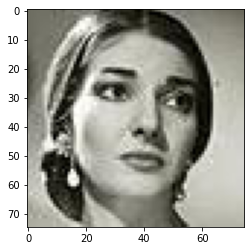

In [152]:
plt.figure()
plt.imshow(plt.imread(dataset.images[0]))

/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/10000_GlennClose_62_f.jpg


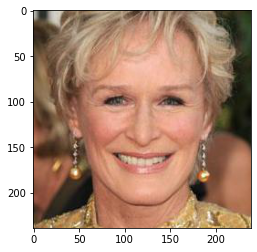

In [153]:
print(dataset.images[1])

plt.figure()
plt.imshow(plt.imread(dataset.images[1]))

In [154]:
dataset.labels[1]

{'age': 62, 'gender': 1, 'person': 'GlennClose'}

## Data Visualization

In [155]:
age = []
gender = []
for i in range(len(dataset)):
    age.append(dataset.labels[i]['age'])
    gender.append(dataset.labels[i]['gender'])

In [156]:
print("Highest Age Value: "+str(max(age))+"\nLowest Age Value: "+str(min(age)))

Highest Age Value: 101
Lowest Age Value: 1


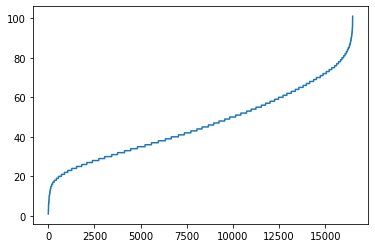

In [157]:
plt.plot(sorted(age))
plt.show()

In [158]:
listofzeros = [0] * len(dataset)
same_age = [i for i in range(min(age), max(age) + 1)]

age_number = dict(zip(same_age, listofzeros))
copy_age = age_number.copy()
age_number

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0}

In [159]:
for i in range(len(dataset)):
    if dataset.labels[i]['age'] in age_number:
        age_number[dataset.labels[i]['age']] += 1
    
age_number

{1: 1,
 2: 0,
 3: 8,
 4: 2,
 5: 4,
 6: 8,
 7: 11,
 8: 8,
 9: 6,
 10: 13,
 11: 20,
 12: 14,
 13: 22,
 14: 23,
 15: 43,
 16: 52,
 17: 82,
 18: 120,
 19: 110,
 20: 161,
 21: 163,
 22: 183,
 23: 212,
 24: 259,
 25: 284,
 26: 275,
 27: 304,
 28: 347,
 29: 313,
 30: 385,
 31: 316,
 32: 378,
 33: 338,
 34: 362,
 35: 413,
 36: 347,
 37: 370,
 38: 382,
 39: 321,
 40: 386,
 41: 320,
 42: 356,
 43: 325,
 44: 281,
 45: 342,
 46: 287,
 47: 289,
 48: 311,
 49: 267,
 50: 317,
 51: 287,
 52: 310,
 53: 250,
 54: 258,
 55: 294,
 56: 227,
 57: 243,
 58: 246,
 59: 213,
 60: 245,
 61: 207,
 62: 238,
 63: 218,
 64: 193,
 65: 231,
 66: 177,
 67: 177,
 68: 215,
 69: 150,
 70: 216,
 71: 145,
 72: 175,
 73: 156,
 74: 138,
 75: 158,
 76: 109,
 77: 104,
 78: 106,
 79: 76,
 80: 91,
 81: 76,
 82: 68,
 83: 57,
 84: 43,
 85: 58,
 86: 35,
 87: 30,
 88: 21,
 89: 19,
 90: 19,
 91: 17,
 92: 11,
 93: 15,
 94: 7,
 95: 9,
 96: 2,
 97: 1,
 98: 2,
 99: 1,
 100: 2,
 101: 1}

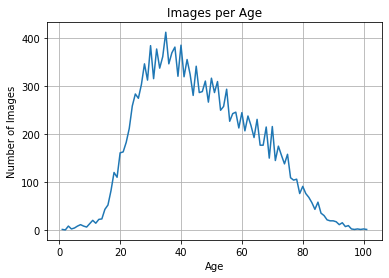

In [160]:
age_amount = age_number.items()
x, y = zip(*age_amount)

plt.plot(x, y)
plt.title("Images per Age")
plt.xlabel("Age")
plt.ylabel("Number of Images")

plt.grid()
plt.show()  

In [161]:
num_gender = {0: 0, 1: 0}
for i in range(len(dataset)):                         # {'m': 0, 'f': 1}
    if dataset.labels[i]['gender'] in num_gender:
        num_gender[dataset.labels[i]['gender']] += 1
    
num_gender

{0: 9788, 1: 6700}

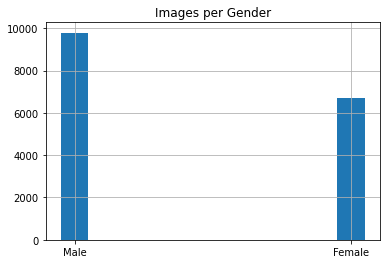

In [162]:
gender_amount = num_gender.items()
_, y = zip(*gender_amount)

plt.title("Images per Gender")

plt.grid()
plt.bar(['Male', 'Female'], y, width = 0.1)
plt.show()  

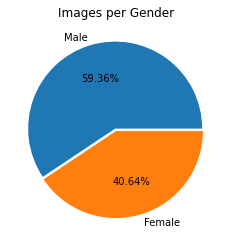

In [163]:
gender_amount = num_gender.items()
_, y = zip(*gender_amount)

plt.title("Images per Gender")
mylabels = ["Male", "Female"]
myexplode = [0.03, 0]

plt.grid()
plt.pie(y, labels = mylabels, explode = myexplode, autopct='%1.2f%%')
plt.show() 

In [164]:
people = []
for i in range(len(dataset)):
    if dataset.labels[i]['person'] not in people:
        people.append(dataset.labels[i]['person'])
sorted(people)

['AbeVigoda',
 'AdolfHitlerr',
 'AlCorley',
 'AlKapone',
 'AlPacino',
 'AlainDelon',
 'AlanRickman',
 'AlanYoung',
 'AlbertCamus',
 'AlbertSchweitzer',
 'AlbertoSordi',
 'AlecGuinness',
 'AlejandroRey',
 'AlexanderGrahamBell',
 'AlexandrakisAlekos',
 'AliMacGraw',
 'AlikiBoug',
 'AmandaBlake',
 'AmandaRedman',
 'AndreMarieAmpКre',
 'AndreasPapantreou',
 'AndyGriffith',
 'AngelaLansbury',
 'AngieDickinson',
 'AnitaEkberg',
 'AnjelicaHuston',
 'AnnJillian',
 'AnnMargret',
 'AnnMiller',
 'AnnaMassey',
 'AnneBancroft',
 'AnneBaxter',
 'AnnetteBening',
 'AnnieGirardot',
 'AnthonyAndrews',
 'AnthonyHopkins',
 'AnthonyPerkins',
 'AnthonyQuayle',
 'Arletty',
 'ArmandAssante',
 'ArnoldSchwarzenegger',
 'AudreyHepburn',
 'AvaGardner',
 'BarbaraBain',
 'BarbaraBouchet',
 'BarbaraStanwyck',
 'BarbraStreisand',
 'BeaArthur',
 'BenGazzara',
 'BernadetteLafont',
 'BerryGordy',
 'BertrandRussell',
 'BetteDavis',
 'BetteMidler',
 'BettyGarrett',
 'BettyGrable',
 'BeverlyRoberts',
 'BillCosby',
 'BillMu

In [165]:
len(people)

567

In [166]:
male_age = copy_age.copy()
female_age = copy_age.copy()

for i in range(len(dataset)):                         # {'m': 0, 'f': 1}
    if dataset.labels[i]['gender'] == 0:
        male_age[dataset.labels[i]['age']] += 1
    elif dataset.labels[i]['gender'] == 1:
        female_age[dataset.labels[i]['age']] += 1
    else:
        print("Something is not right")
    
male_age

{1: 1,
 2: 0,
 3: 6,
 4: 1,
 5: 2,
 6: 2,
 7: 7,
 8: 4,
 9: 2,
 10: 10,
 11: 10,
 12: 7,
 13: 6,
 14: 9,
 15: 16,
 16: 22,
 17: 37,
 18: 49,
 19: 38,
 20: 68,
 21: 51,
 22: 70,
 23: 80,
 24: 111,
 25: 119,
 26: 116,
 27: 140,
 28: 169,
 29: 159,
 30: 213,
 31: 164,
 32: 211,
 33: 176,
 34: 209,
 35: 243,
 36: 204,
 37: 234,
 38: 246,
 39: 196,
 40: 242,
 41: 197,
 42: 227,
 43: 203,
 44: 184,
 45: 227,
 46: 178,
 47: 175,
 48: 203,
 49: 168,
 50: 206,
 51: 190,
 52: 218,
 53: 164,
 54: 177,
 55: 189,
 56: 149,
 57: 170,
 58: 162,
 59: 139,
 60: 164,
 61: 137,
 62: 161,
 63: 144,
 64: 119,
 65: 172,
 66: 118,
 67: 119,
 68: 146,
 69: 98,
 70: 144,
 71: 89,
 72: 118,
 73: 100,
 74: 95,
 75: 103,
 76: 68,
 77: 61,
 78: 63,
 79: 51,
 80: 60,
 81: 48,
 82: 40,
 83: 36,
 84: 23,
 85: 30,
 86: 16,
 87: 18,
 88: 12,
 89: 12,
 90: 10,
 91: 9,
 92: 8,
 93: 9,
 94: 4,
 95: 6,
 96: 0,
 97: 1,
 98: 0,
 99: 0,
 100: 0,
 101: 0}

In [167]:
female_age

{1: 0,
 2: 0,
 3: 2,
 4: 1,
 5: 2,
 6: 6,
 7: 4,
 8: 4,
 9: 4,
 10: 3,
 11: 10,
 12: 7,
 13: 16,
 14: 14,
 15: 27,
 16: 30,
 17: 45,
 18: 71,
 19: 72,
 20: 93,
 21: 112,
 22: 113,
 23: 132,
 24: 148,
 25: 165,
 26: 159,
 27: 164,
 28: 178,
 29: 154,
 30: 172,
 31: 152,
 32: 167,
 33: 162,
 34: 153,
 35: 170,
 36: 143,
 37: 136,
 38: 136,
 39: 125,
 40: 144,
 41: 123,
 42: 129,
 43: 122,
 44: 97,
 45: 115,
 46: 109,
 47: 114,
 48: 108,
 49: 99,
 50: 111,
 51: 97,
 52: 92,
 53: 86,
 54: 81,
 55: 105,
 56: 78,
 57: 73,
 58: 84,
 59: 74,
 60: 81,
 61: 70,
 62: 77,
 63: 74,
 64: 74,
 65: 59,
 66: 59,
 67: 58,
 68: 69,
 69: 52,
 70: 72,
 71: 56,
 72: 57,
 73: 56,
 74: 43,
 75: 55,
 76: 41,
 77: 43,
 78: 43,
 79: 25,
 80: 31,
 81: 28,
 82: 28,
 83: 21,
 84: 20,
 85: 28,
 86: 19,
 87: 12,
 88: 9,
 89: 7,
 90: 9,
 91: 8,
 92: 3,
 93: 6,
 94: 3,
 95: 3,
 96: 2,
 97: 0,
 98: 2,
 99: 1,
 100: 2,
 101: 1}

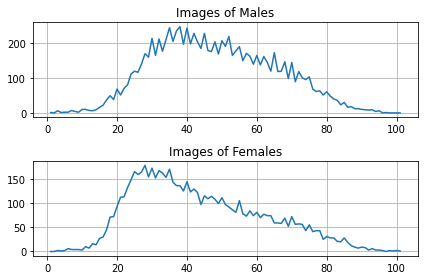

In [168]:
#plot 1:
male_amount = male_age.items()
x, y = zip(*male_amount)

plt.subplot(2, 1, 1)
plt.grid()
plt.plot(x,y)
plt.title("Images of Males")

#plot 2:
female_amount = female_age.items()
x, y = zip(*female_amount)

plt.subplot(2, 1, 2)
plt.grid()
plt.plot(x,y)
plt.title("Images of Females")

plt.tight_layout()
plt.show()

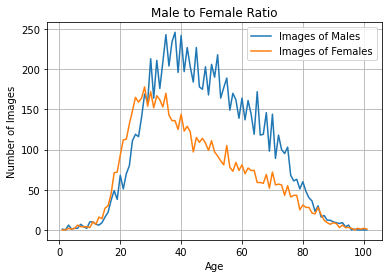

In [169]:
#plot 1:
male_amount = male_age.items()
x1, y1 = zip(*male_amount)

#plot 2:
female_amount = female_age.items()
x2, y2 = zip(*female_amount)

plt.plot(x1, y1)
plt.plot(x2, y2)

plt.legend(["Images of Males", "Images of Females"])

plt.title("Male to Female Ratio")
plt.xlabel("Age")
plt.ylabel("Number of Images")

plt.grid()

plt.show()

# Training Testing

## Split Dataset

In [170]:
# hyper params

train_set, validation_set, test_set = dataset.get_loaders(
    transform=ToTensor(),
    batch_size=1,
    train_size=0.7,
    test_size=0.2,
)

In [171]:
len(train_set), len(validation_set), len(test_set)

(11541, 1650, 3297)

In [172]:
sum = len(train_set) + len(validation_set) + len(test_set)
sum == len(dataset)

True